# Speech enhancement

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/speech-enhancement](https://github.com/huseinzol05/malaya-speech/tree/master/example/speech-enhancement).
    
</div>

<div class="alert alert-info">

This module is language independent, so it save to use on different languages. Pretrained models trained on multilanguages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

### Dataset

Trained on English, Manglish and Bahasa podcasts with augmented noises, gathered at https://github.com/huseinzol05/malaya-speech/tree/master/data/podcast

Purpose of this module to enhance voice activities, reduce reverberance, reduce loudness and broken voices.

**voice -> malaya-speech noise reduction -> malaya-speech speech enhancement -> perfecto**.

In [1]:
import malaya_speech
import numpy as np
from malaya_speech import Pipeline

In [2]:
y, sr = malaya_speech.load('speech/khutbah/wadi-annuar.wav', sr = 44100)
len(y), sr, len(y) / sr

(441000, 44100, 10.0)

So total length is 10 seconds.

In [3]:
import IPython.display as ipd
ipd.Audio(y[:10 * sr], rate = sr)

The speech got room echo and a bit of broken high pitch, because it recorded in mosque.

### List available deep model

In [4]:
malaya_speech.speech_enhancement.available_model()

INFO:root:Only calculate SDR, ISR, SAR on voice sample. Higher is better.


Size (MB)  Quantized Size (MB)  SUM MAE  MAE_SPEAKER  MAE_NOISE  \
unet              78.9                 20.0  0.85896     0.468490   0.390460   
resnet-unet       96.4                 24.6  0.81540     0.447958   0.367441   

                   SDR       ISR        SAR  
unet         12.128050  14.67067  15.019682  
resnet-unet  12.349259  14.85418  15.217510

### Load deep model

In [5]:
model = malaya_speech.speech_enhancement.deep_model(model = 'resnet-unet')

#### Load Quantized model

To load 8-bit integer quantized model, simply pass `quantized = True`, default is `False`.

We can expect slightly accuracy drop from quantized model, and not necessary faster than normal 32-bit float model, totally depends on machine.

In [6]:
quantized_model = malaya_speech.speech_enhancement.deep_model(model = 'resnet-unet', quantized = True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


### Important factor

1. Noise Reduction model trained on 44k sample rate, so make sure load the audio with 44k sample rate.

```python
malaya_speech.load(audio_file, sr = 44100)
librosa.load(audio_file, sr = 44100)
```

2. You can feed dynamic length of audio, no need to cap, the model do padding by itself. But again, the longer the audio, the longer time required to calculate, unless you have GPU to speed up.
3. STFT and Inverse STFT can be done on GPU level, so the model is really fast on GPU.

In [7]:
%%time

output = model(y)

CPU times: user 4.81 s, sys: 932 ms, total: 5.74 s
Wall time: 2.02 s


In [8]:
output

{'voice': array([1.9417714e-08, 2.0993056e-08, 2.4434440e-08, ..., 2.1756661e-01,
        1.9999057e-01, 1.4723262e-01], dtype=float32),
 'noise': array([-1.9704540e-08, -2.3319327e-08, -2.4154849e-08, ...,
         1.5757367e-01,  1.5660551e-01,  9.5091663e-02], dtype=float32)}

In [9]:
ipd.Audio(output['voice'], rate = sr)

Nicely done! How about our quantized model?

In [10]:
%%time

output_quantized = quantized_model(y)
output_quantized

CPU times: user 4.75 s, sys: 794 ms, total: 5.55 s
Wall time: 1.69 s


{'voice': array([       nan,        nan,        nan, ..., 0.24860458, 0.22949845,
        0.17663977], dtype=float32),
 'noise': array([       nan,        nan,        nan, ..., 0.12567902, 0.1265097 ,
        0.06609032], dtype=float32)}

Not that good, we can try to listen by replace NaN with 0.

In [11]:
ipd.Audio(np.nan_to_num(output_quantized['voice']), rate = sr)

### Use Pipeline

Incase your audio is too long and you do not want to burden your machine. So, you can use malaya-speech Pipeline to split the audio splitted to 15 seconds and predict one-by-one and combine after that.

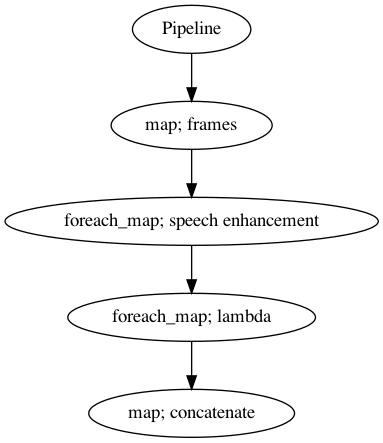

In [12]:
p = Pipeline()
pipeline = (
    p.map(malaya_speech.generator.frames, frame_duration_ms = 15000, sample_rate = sr)
    .foreach_map(model)
    .foreach_map(lambda x: x['voice'])
    .map(np.concatenate)
)
p.visualize()

In [13]:
%%time

results = p.emit(y)

CPU times: user 4.22 s, sys: 676 ms, total: 4.9 s
Wall time: 949 ms


In [14]:
results.keys()

dict_keys(['frames', 'speech-enhancement', '<lambda>', 'concatenate'])

In [15]:
ipd.Audio(results['concatenate'], rate = sr)